# Thermostats 

## Berendsen Thermostat

The Berendsen Thermostat (BT) uses a tapered velocity scaling approach. In a strict velocity scaling approach
the temperature $T_e$ is estimated, through a quantity proportional to $\langle v^2 \rangle$,
and the velocities are scaled to values consistent with the desired temperature $T_d$,
as in $v_i \mapsto \alpha v_i$. Being completely consistent with physical laws,
it is preferable to use the same simple algorithm but more gently so that the dynamics during the thermostat period is more consistent with the underlying equations of motion.
In the BT we begin with an model for the temperature as we would like to see it evolve over a slower
timescale $\tau_{B}$. One model is

$$
   \frac{dT}{dt} = \frac{T_d - T}{\tau_{B}},
$$

This equation can be solved analytically to yield

$$
   T(t) = T(0)e^{-t/\tau_B} + \left(1 - e^{-t/\tau_B}  \right)T_d ,
$$

which can be seen to transition from the initial temperature $T(0)$ to the desired temperature $T_d$
on a time scale of $\tau_{B}$. By choosing $\tau_{B}$ to be many timesteps we can eventually equilibrate
the system while allowing it to explore configurations closer to the real (not velocity scaled) dynamics.

To implement BT we discretize the BT model across one time step to obtain

$$
   T(t + \Delta t) = T(t) + \frac{\Delta t}{\tau_B}\left(T_d - T(t) \right).
$$

We want to scale the current velocities such that this new temperature $T(t+\Delta t)$ is achieved,
because that the temperature prescribed by the BT.
Finding the ratio then of the target temperature and the current temperature, we get

$$
   \frac{T(t + \Delta t)}{T(t) } = 1+ \frac{\Delta t}{\tau_{B}}\left(\frac{T_d}{T(t) } - 1 \right).
$$

Taking the square root of this yields the scaling factor for the velocities:

$$
\alpha = \sqrt{ 1+ \frac{\Delta t}{\tau_{B}}\left(\frac{T_d}{T(t) } - 1 \right) }.
$$

Below we show an example notebook that runs Sarkas for different $\tau_B$ values.

In [1]:
# Import the usual libraries
%pylab
%matplotlib inline
import os
plt.style.use('MSUstyle')
# Import sarkas
from sarkas.processes import Simulation, PostProcess

# Create the file path to the YAML input file
input_file_name = os.path.join('input_files', 'yocp_cgs_pp_therm.yaml' )



Using matplotlib backend: <object object at 0x7fe2257efb50>
Populating the interactive namespace from numpy and matplotlib


We select six different values of $\tau_B$ and for each of them run a simulation.

In [2]:
taus = np.array([ 1.0, 2.0, 5.0, 10., 50., 100. ])

for i, tau in enumerate(taus):
    args = {
        'Integrator': {'thermalization_timestep': 100,
                       'berendsen_tau': tau}, # Change tau for each simulation
            
            "IO":   # Store all simulations' data in simulations_dir,
                # but save the dumps in different subfolders (job_dir)
            {
                "simulations_dir": 'Berendsen_runs',
                "job_dir": "tau_{}".format(int(tau) ),
                "verbose": False # This is so not to print to screen for every run
            },
            "Parameters":{ "rand_seed": 123456}
        
    }
    # Run the simulation.
    sim = Simulation(input_file_name)
    sim.setup(read_yaml=True, other_inputs=args)
    sim.run()
    
    print('Tau = {} Done'.format(tau))

Tau = 1.0 Done
Tau = 2.0 Done
Tau = 5.0 Done
Tau = 10.0 Done
Tau = 50.0 Done
Tau = 100.0 Done


Now we plot the temperature evolution to show the effect of changing $\tau_B$.

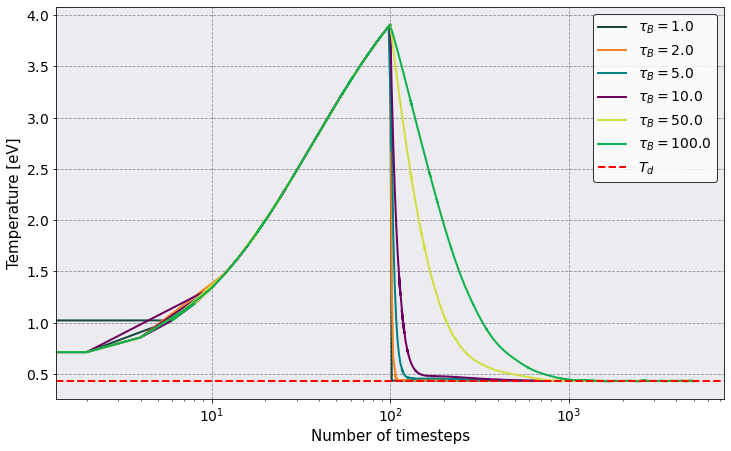

In [3]:
fig, axt = plt.subplots(1,1, figsize = (12,9))

for i, tau in enumerate(taus):
    args = {
       'Integrator': {'thermalization_timestep': 100,
                       'berendsen_tau': tau},

            "IO":   # Store all simulations' data in simulations_dir,
                # but save the dumps in different subfolders (job_dir)
            {
                "simulations_dir": 'Berendsen_runs',
                "job_dir": "tau_{}".format(int(tau) ),
                "verbose": False # This is so not to print to screen for every run
            },
    }

    postproc = PostProcess(input_file_name)
    postproc.setup(read_yaml=True, other_inputs = args)
    postproc.therm.setup(postproc.parameters, phase = 'equilibration')
    postproc.therm.parse()
    postproc.therm.plot(
        scaling = (postproc.therm.dt, postproc.parameters.eV2K),   
        y = 'Temperature', 
        ylabel = 'Temperature [eV]',
        xlabel = 'Number of timesteps', logx = True, ax = axt)

axt.axhline(postproc.parameters.species_temperatures_eV[0], ls = '--', color = 'r')
axt.legend([
    r'$\tau_B = 1.0$', 
    r'$\tau_B = 2.0$',
    r'$\tau_B = 5.0$',
    r'$\tau_B = 10.0$',
    r'$\tau_B = 50.0$',
    r'$\tau_B = 100.0$',
    r'$T_d$'])

As you can see, the temperature increase for the first hundred time steps. The reason being that we selected the option `thermalization_timestep: 100`. We do this to allow the system to transform all of its initial potential energy into kinetic energy. 